In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import numpy as np
import scipy
import os
from PIL import Image






2024-02-13 12:17:22.689065: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 12:17:22.768259: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 12:17:23.133475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 12:17:23.133513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 12:17:23.207519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Load the EfficientNetV2B0 model pre-trained on ImageNet data
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(32, 32, 3),
    pooling='max'
)

base_model.trainable= True

# Input dimensions
image_width = 32
image_height = 32
channels = 3

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  
])

model.summary()

2024-02-13 12:17:26.448299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-13 12:17:26.448962: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 24089601 (91.89 MB)
Trainable params: 24044161 (91.72 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


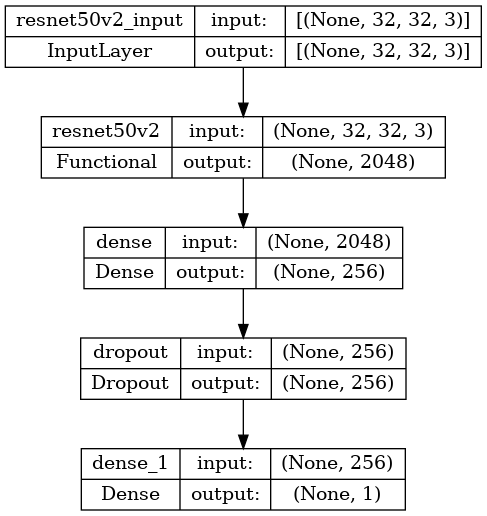

In [3]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [4]:
# Define image size and batch size
img_size = (32, 32)
batch_size = 160

# Training data generator with normalization / rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=40,  # Randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # Randomly horizontally shift images
    height_shift_range=0.2,  # Randomly vertically shift images
    shear_range=0.2,  # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range=0.2,  # Randomly zoom image 
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Strategy used for filling in newly created pixels
)

# Test data generator with normalization / rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'  # 'binary' for two classes, REAL AND FAKE
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test/',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
train_class_indices = train_generator.class_indices
test_class_indices = test_generator.class_indices

print("Training class indices:", train_class_indices)
print("Testing class indices:", test_class_indices)

# Initialize counters
train_counts = {class_name: 0 for class_name in train_class_indices.keys()}
test_counts = {class_name: 0 for class_name in test_class_indices.keys()}

# Count for training data
for filename in train_generator.filenames:
    class_name = filename.split('/')[0] 
    train_counts[class_name] += 1

# Count for testing data
for filename in test_generator.filenames:
    class_name = filename.split('/')[0]  
    test_counts[class_name] += 1

print("Training images per class:", train_counts)
print("Testing images per class:", test_counts)


Training class indices: {'FAKE': 0, 'REAL': 1}
Testing class indices: {'FAKE': 0, 'REAL': 1}
Training images per class: {'FAKE': 50000, 'REAL': 50000}
Testing images per class: {'FAKE': 10000, 'REAL': 10000}


In [6]:
model.compile(optimizer=Adamax(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=[BinaryAccuracy(name='Accuracy'), Precision(name='Precision'), Recall(name='Recall')]
             )


In [7]:
def scheduler(epoch, lr):
    if epoch <= 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
        
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(
    train_generator,
    validation_data=test_generator,
    batch_size=batch_size,
    epochs=20,
    callbacks=[callback_scheduler]
)


Epoch 1/20
625/625 [==============================] - 310s 485ms/step - loss: 0.3668 - Accuracy: 0.8387 - Precision: 0.8279 - Recall: 0.8552 - val_loss: 0.4162 - val_Accuracy: 0.8480 - val_Precision: 0.9733 - val_Recall: 0.7157 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 299s 479ms/step - loss: 0.2446 - Accuracy: 0.9006 - Precision: 0.8973 - Recall: 0.9046 - val_loss: 0.3523 - val_Accuracy: 0.8700 - val_Precision: 0.9799 - val_Recall: 0.7555 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 295s 472ms/step - loss: 0.2209 - Accuracy: 0.9123 - Precision: 0.9098 - Recall: 0.9154 - val_loss: 0.2320 - val_Accuracy: 0.9075 - val_Precision: 0.9669 - val_Recall: 0.8439 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 297s 476ms/step - loss: 0.2106 - Accuracy: 0.9162 - Precision: 0.9137 - Recall: 0.9192 - val_loss: 0.2136 - val_Accuracy: 0.9102 - val_Precision: 0.9771 - val_Recall: 0.8401 - lr: 0.0010
Epoch 5/20
625/625 [================

In [8]:
model.save('my_model.keras')

import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_models')


/home/thiha/wgu_capstone/my-model/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print("Test accuracy: ", test_accuracy)


125/125 [==============================] - 12s 92ms/step - loss: 0.1998 - Accuracy: 0.9261 - Precision: 0.9910 - Recall: 0.8600
Test accuracy:  0.9261000156402588


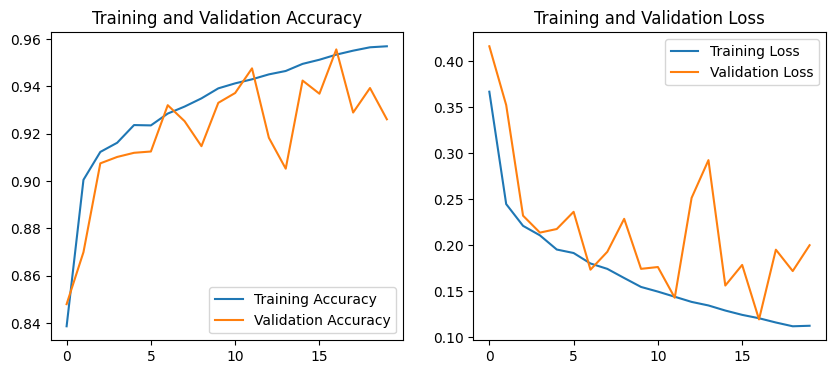

In [10]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

## Training and Accuracy Graphs
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']

# Get training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = 20

# Visualize accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), acc, label='Training Accuracy')
plt.plot(range(num_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Visualize loss
plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), loss, label='Training Loss')
plt.plot(range(num_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig("training_validation.png")
plt.show()

plt.close()
#################################################################################






125/125 [==============================] - 12s 90ms/step
[0 0 0 ... 1 1 1]
tf.Tensor(
[[5703 4297]
 [5619 4381]], shape=(2, 2), dtype=int32)


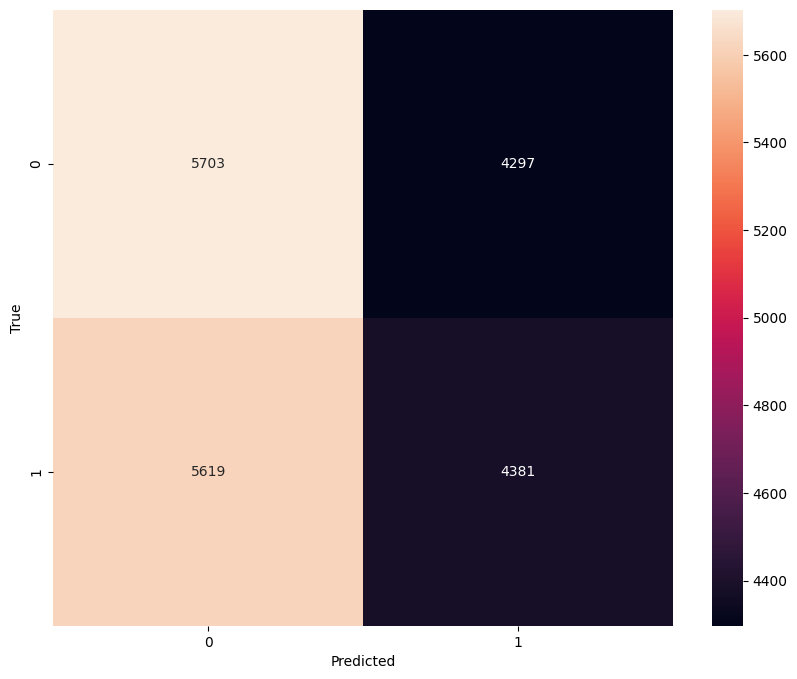

In [11]:
## Confusion Matrix Heat Map ##
predictions = model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype("int32")
true_classes = test_generator.classes

cm = tf.math.confusion_matrix(test_generator.classes, predicted_classes)
print(test_generator.classes)


print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("heat_map.png")
plt.show()

plt.close()